## Imports

In [12]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from typing import Literal
from keras import optimizers
from keras import losses
from keras import metrics

from src.models import CustomFFNN
from src.data_import import load_naive_dataset
from src.plots import plot_predictions, plot_loss, plot_heatmap
from src.utils import get_scores

## Paths

In [2]:
# Calibration paths
calibration_dir = os.path.abspath('calibration')
biaxial_path = os.path.join(calibration_dir, 'biaxial.txt')
pure_shear_path = os.path.join(calibration_dir, 'pure_shear.txt')
uniaxial_path = os.path.join(calibration_dir, 'uniaxial.txt')

# Test paths
test_dir = os.path.abspath('test')
biax_test_path = os.path.join(test_dir, 'biax_test.txt')
mixed_test_path = os.path.join(test_dir, 'mixed_test.txt')

## Load Datasets

In [3]:
biaxial_features, biaxial_labels = load_naive_dataset(biaxial_path)
pure_shear_features, pure_shear_labels = load_naive_dataset(pure_shear_path)
uniaxial_features, uniaxial_labels = load_naive_dataset(uniaxial_path)

biax_test_features, biax_test_labels = load_naive_dataset(biax_test_path)
mixed_test_features, mixed_test_labels = load_naive_dataset(mixed_test_path)

# Task 2.2 - Naive Model approach

### Model Initialization and Training

In [4]:
train_features = tf.concat([biaxial_features, pure_shear_features, uniaxial_features], axis=0)
train_labels = tf.concat([biaxial_labels, pure_shear_labels, uniaxial_labels], axis=0)

In [5]:
naive_model = CustomFFNN(
    hidden_sizes=[32, 32, 32, 9],
    activations=['softplus', 'softplus', 'softplus', 'linear']
)
naive_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
h = naive_model.fit(train_features, train_labels, batch_size=16, epochs=3000, verbose=0)
loss = h.history['loss']
# val_loss = h.history['val_loss']

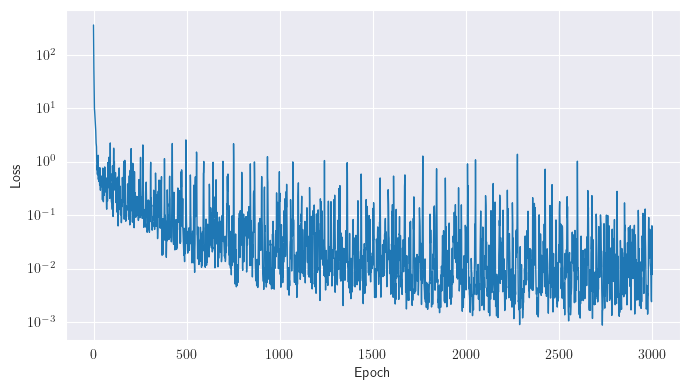

In [6]:
fig = plot_loss(loss)
fig.tight_layout()
plt.show()

### Model Evaluation

#### -- on seen load cases

In [7]:
biaxial_predictions = naive_model.predict(biaxial_features)
pure_shear_predictions = naive_model.predict(pure_shear_features)
uniaxial_predictions = naive_model.predict(uniaxial_features)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


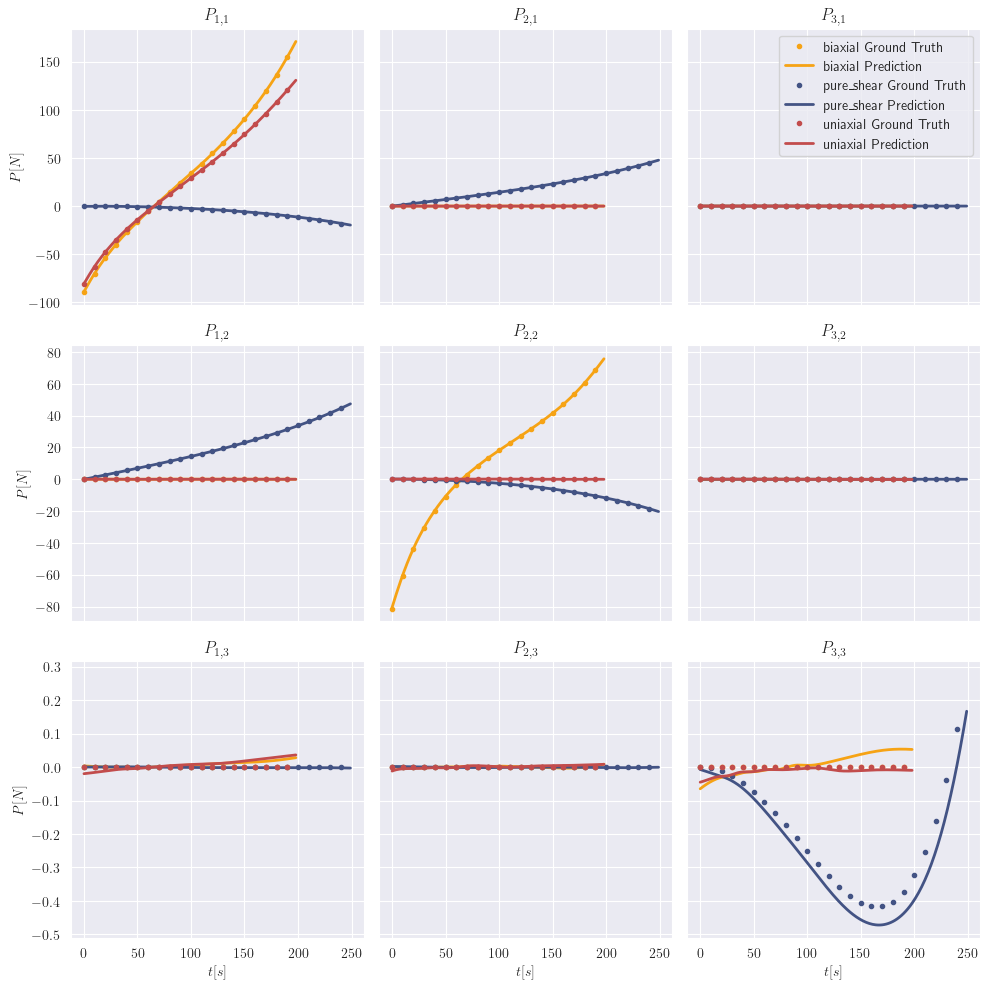

In [8]:
labels = {
    'biaxial': biaxial_labels.numpy(),
    'pure_shear': pure_shear_labels.numpy(),
    'uniaxial': uniaxial_labels.numpy(),
}
predictions = {
    'biaxial': biaxial_predictions,
    'pure_shear': pure_shear_predictions,
    'uniaxial': uniaxial_predictions,
}
fig_train_pred = plot_predictions(labels, predictions)
fig_train_pred.tight_layout()
plt.show()

#### -- on unseen load cases

In [9]:
biax_test_preds = naive_model.predict(biax_test_features)
mixed_test_preds = naive_model.predict(mixed_test_features)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


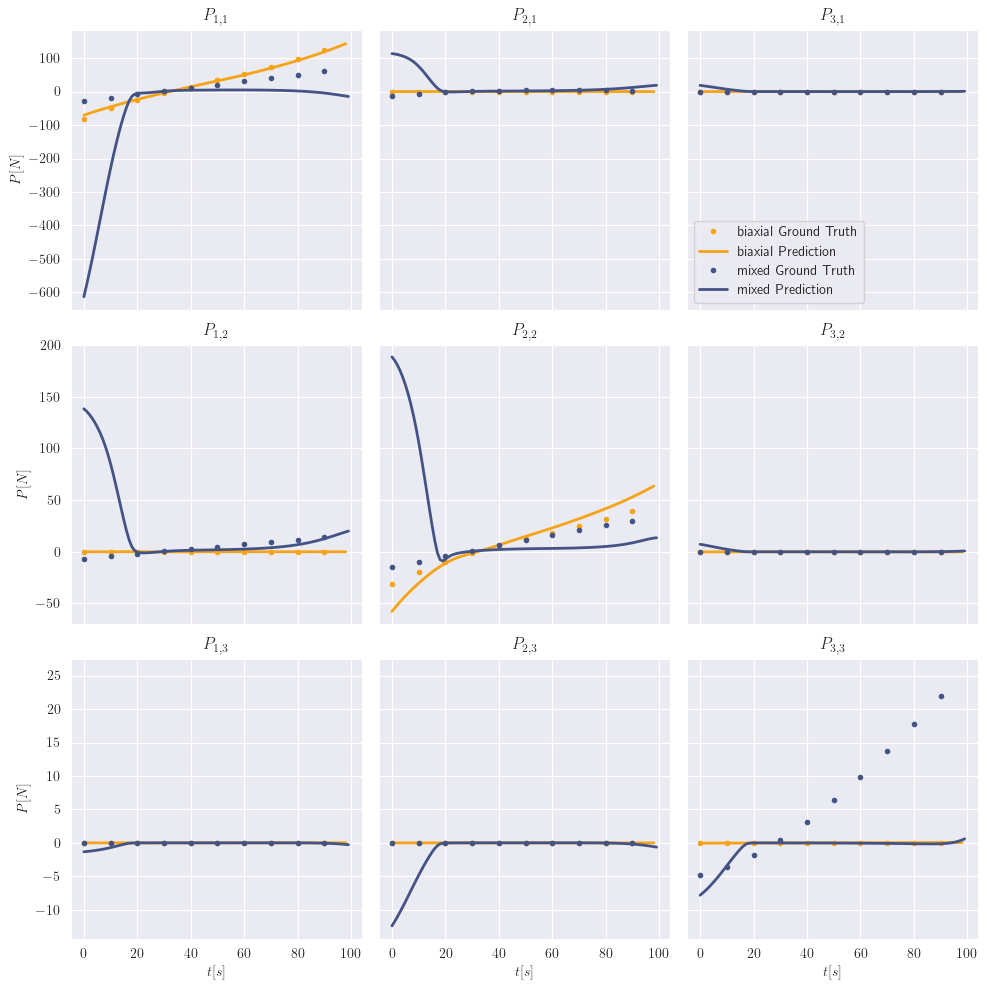

In [10]:
test_labels = {
    'biaxial': biax_test_labels.numpy(),
    'mixed': mixed_test_labels.numpy(),
}
test_predictions = {
    'biaxial': biax_test_preds,
    'mixed': mixed_test_preds,
}
fig_test_pred = plot_predictions(test_labels, test_predictions)
fig_test_pred.tight_layout()
plt.show()

### Get scores

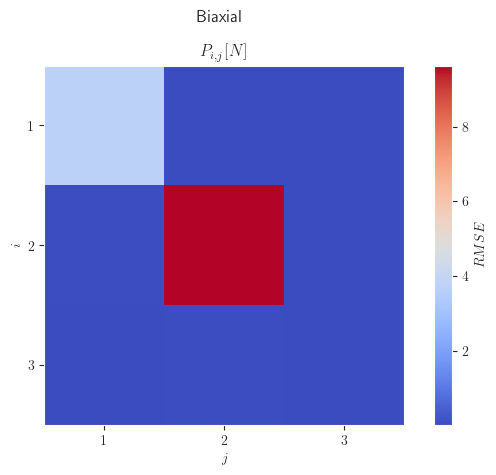

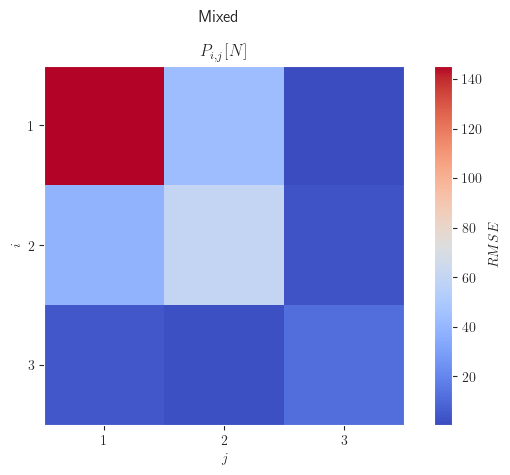

In [13]:
scores = get_scores(test_labels, test_predictions, type='rmse')
for name, values in scores.items():
    fig_heat = plot_heatmap(values, vmin=None, vmax=None, title=name.capitalize(), cbar_label='$RMSE$')
    fig_heat.tight_layout()
    plt.show()

## Loss weighting strategy

In [14]:
def get_weight(tensor: tf.Tensor) -> tf.Tensor:
    batch_size = tensor.shape[0]
    norms = tf.linalg.norm(tensor, axis=1, ord='euclidean')
    weights = tf.reduce_mean(norms)
    return tf.repeat(weights, batch_size)
    
biaxial_weights = get_weight(biaxial_labels)
pure_shear_weights = get_weight(pure_shear_labels)
uniaxial_weights = get_weight(uniaxial_labels)

In [15]:
train_features = tf.concat([biaxial_features, pure_shear_features, uniaxial_features], axis=0)
train_labels = tf.concat([biaxial_labels, pure_shear_labels, uniaxial_labels], axis=0)
sample_weights = tf.concat([biaxial_weights, pure_shear_weights, uniaxial_weights], axis=0)

In [16]:
naive_model_weighted = CustomFFNN( 
    hidden_sizes=[32, 32, 32, 9],
    activations=['softplus', 'softplus', 'softplus', 'linear']
)
naive_model_weighted.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
h = naive_model_weighted.fit(train_features, train_labels, batch_size=16, epochs=5000, verbose=0, sample_weight=sample_weights)
loss = h.history['loss']
# val_loss = h.history['val_loss']

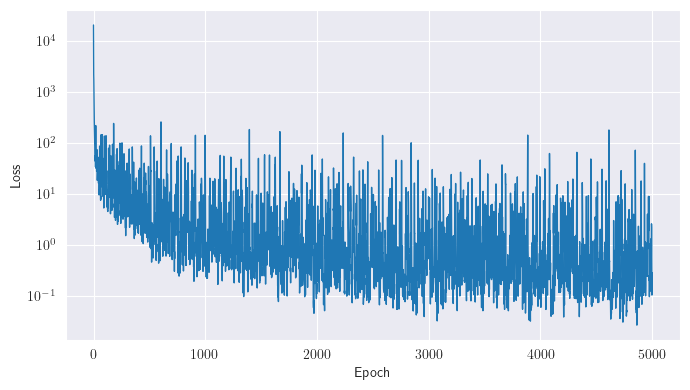

In [17]:
fig = plot_loss(loss)
fig.tight_layout()
plt.show()

### Model Evaluation

#### -- on seen load cases

In [18]:
biaxial_predictions = naive_model_weighted.predict(biaxial_features)
pure_shear_predictions = naive_model_weighted.predict(pure_shear_features)
uniaxial_predictions = naive_model_weighted.predict(uniaxial_features)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


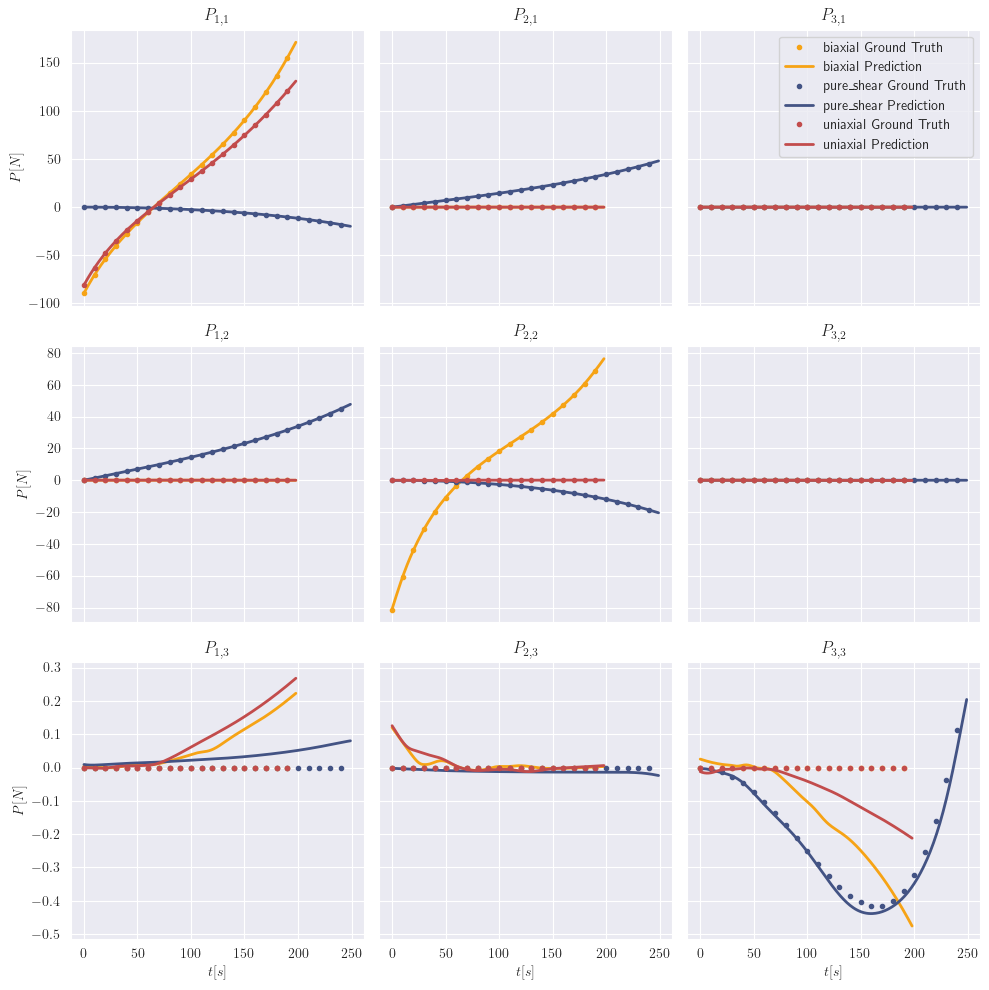

In [19]:
labels = {
    'biaxial': biaxial_labels.numpy(),
    'pure_shear': pure_shear_labels.numpy(),
    'uniaxial': uniaxial_labels.numpy(),
}
predictions = {
    'biaxial': biaxial_predictions,
    'pure_shear': pure_shear_predictions,
    'uniaxial': uniaxial_predictions,
}
fig_train_pred = plot_predictions(labels, predictions)
fig_train_pred.tight_layout()
plt.show()

#### -- on unseen load cases

In [20]:
biax_test_preds = naive_model_weighted.predict(biax_test_features)
mixed_test_preds = naive_model_weighted.predict(mixed_test_features)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


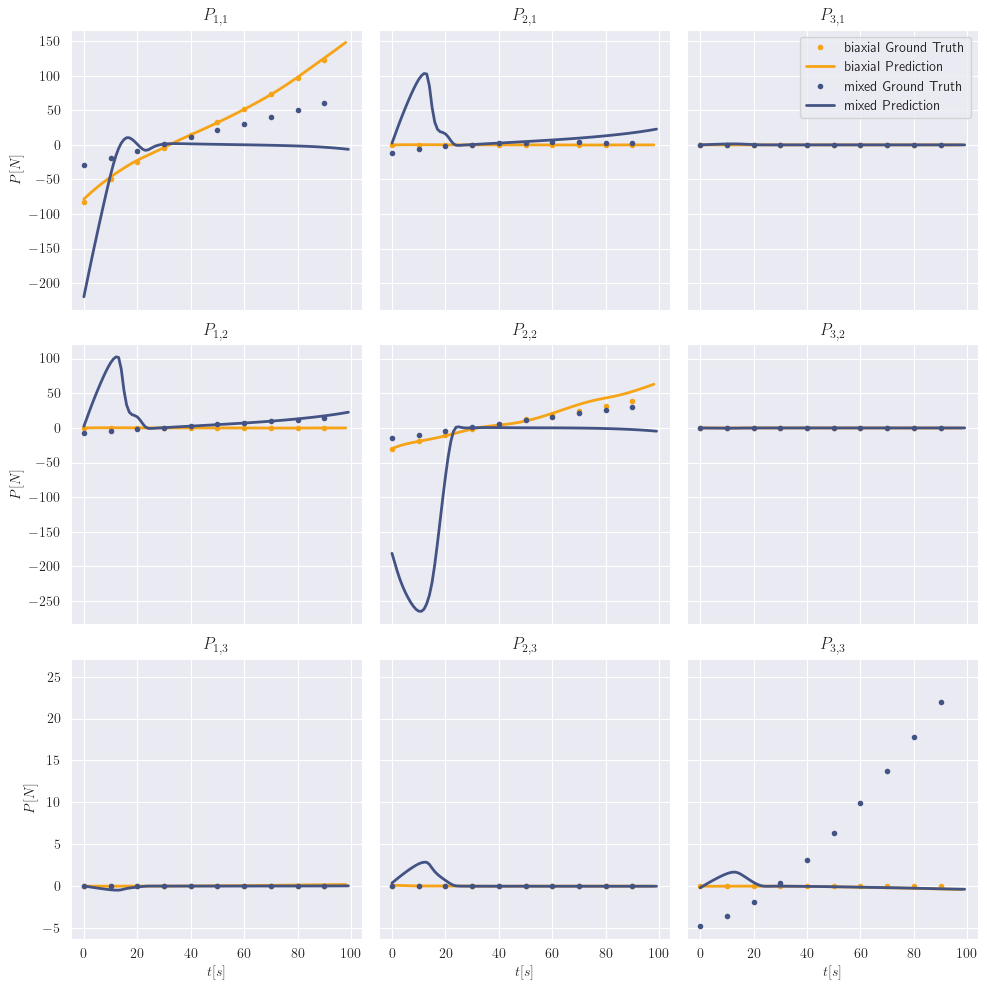

In [21]:
test_labels = {
    'biaxial': biax_test_labels.numpy(),
    'mixed': mixed_test_labels.numpy(),
}
test_predictions = {
    'biaxial': biax_test_preds,
    'mixed': mixed_test_preds,
}
fig_test_pred = plot_predictions(test_labels, test_predictions)
fig_test_pred.tight_layout()
plt.show()

### Get scores

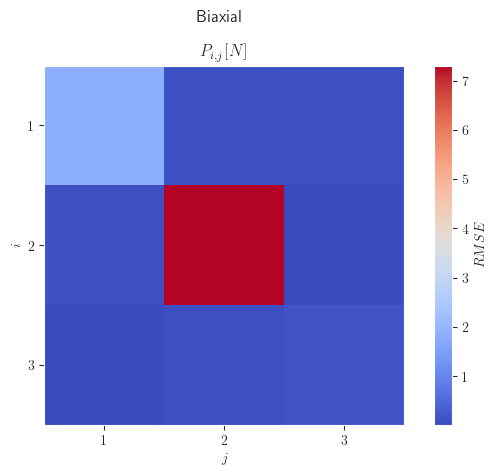

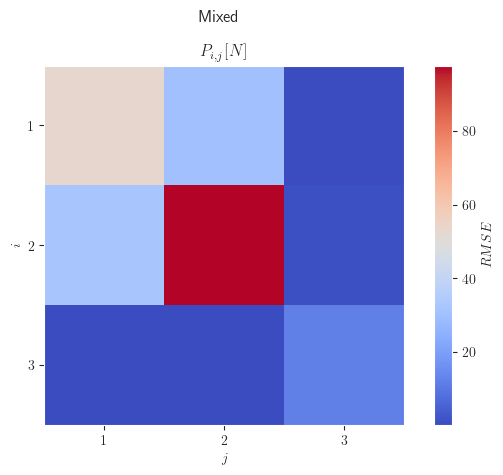

In [22]:
scores = get_scores(test_labels, test_predictions, type='rmse')
for name, values in scores.items():
    fig_heat = plot_heatmap(values, vmin=None, vmax=None, title=name.capitalize(), cbar_label='$RMSE$')
    fig_heat.tight_layout()
    plt.show()